In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

In [2]:
data = pd.read_csv('../input/ph-recognition/ph-data.csv') 
data.head(10)

,blue,green,red,label
0,36,27,231,0
1,36,84,250,1
2,37,164,255,2
3,22,205,255,3
4,38,223,221,4
5,29,214,148,5
6,0,181,76,6
7,13,156,0,7
8,92,166,0,8
9,184,191,0,9


In [3]:
data.duplicated().sum() 

206

In [4]:
data = data.drop_duplicates()

In [5]:
(data.isna().mean()*100).round(1)

blue     0.0
green    0.0
red      0.0
label    0.0
dtype: float64

In [6]:
data.describe()

,blue,green,red,label
count,447.000000,447.000000,447.000000,447.000000
mean,86.317673,127.093960,122.928412,6.988814
std,77.707929,74.450936,91.448455,4.283387
min,0.000000,0.000000,0.000000,0.000000
25%,13.500000,62.500000,50.500000,3.000000
50%,63.000000,143.000000,96.000000,7.000000
75%,161.000000,189.500000,224.000000,11.000000
max,255.000000,255.000000,255.000000,14.000000


<AxesSubplot:xlabel='label', ylabel='Count'>

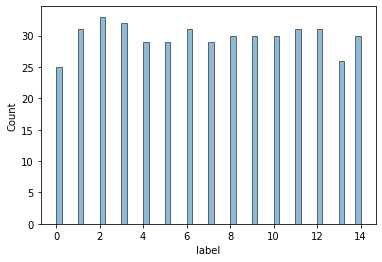

In [8]:
sns.histplot(data['label'], bins=56, alpha=.5)

In [9]:
target = data['label']
features = data.drop('label', axis=1)

  
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [10]:
def rmse(y_actual, y_predicted):
    from sklearn.metrics import mean_squared_error
    from math import sqrt
    return sqrt(mean_squared_error(y_actual, y_predicted))

In [11]:
def best_hiper_search(features_train, target_train):
    parametrs_DTR = {'max_depth': range (1,13, 1)}
    parametrs_RFR = {'n_estimators': range (10, 51, 20),'max_depth': range (1,10, 2)}
    parametrs_LR = {'fit_intercept':[True,False]}
    parametrs_XGB = {'n_estimators': range (2200, 2500, 50)}
    
    rmse_scorer = make_scorer(rmse, greater_is_better=True)
    
    
    grid_DTR = GridSearchCV(DecisionTreeRegressor(), parametrs_DTR, cv=5, scoring=rmse_scorer)
    grid_RFR = GridSearchCV(RandomForestRegressor(), parametrs_RFR, cv=5, scoring=rmse_scorer)
    grid_LR = GridSearchCV(LinearRegression(), parametrs_LR, cv=5, scoring=rmse_scorer)
    grid_XGB = GridSearchCV(XGBRegressor(), parametrs_XGB,scoring=rmse_scorer)
    
    
    grid_DTR.fit(features_train, target_train)
    grid_RFR.fit(features_train, target_train)
    grid_LR.fit(features_train, target_train)
    grid_XGB.fit(features_train, target_train)
    
  
    print("DecisionTreeRegressor", grid_DTR.scorer_, grid_DTR.best_score_, grid_DTR.best_params_)
    print("RandomForestRegressor", grid_RFR.scorer_, grid_RFR.best_score_, grid_RFR.best_params_)
    print("LinearRegression", grid_LR.scorer_, grid_LR.best_score_, grid_LR.best_params_)
    print("XGBRegressor", grid_XGB.scorer_, grid_XGB.best_score_, grid_XGB.best_params_)
    return


print("Selection of hyperparameters:")
best_hiper_search(features_train, target_train)
print('')


Selection of hyperparameters:
DecisionTreeRegressor make_scorer(rmse) 2.4842086686585616 {'max_depth': 1}
RandomForestRegressor make_scorer(rmse) 2.412721926828924 {'max_depth': 1, 'n_estimators': 10}
LinearRegression make_scorer(rmse) 3.0686793120648943 {'fit_intercept': False}
XGBRegressor make_scorer(rmse) 1.390193861482655 {'n_estimators': 2200}



In [12]:
model_xgb = XGBRegressor(n_estimators=2200,learning_rate=0.05)

In [13]:
model_xgb.fit(features_train, target_train)
xgb_pred = model_xgb.predict(features_test)
print('RMSE -', mean_squared_error(target_test, xgb_pred)**0.5)

RMSE - 0.989135684349785


In [14]:
from sklearn.metrics import accuracy_score
accuracy = model_xgb.score(features_test, target_test)
print("Аccuracy", ":", accuracy)

Аccuracy : 0.9442988328710062


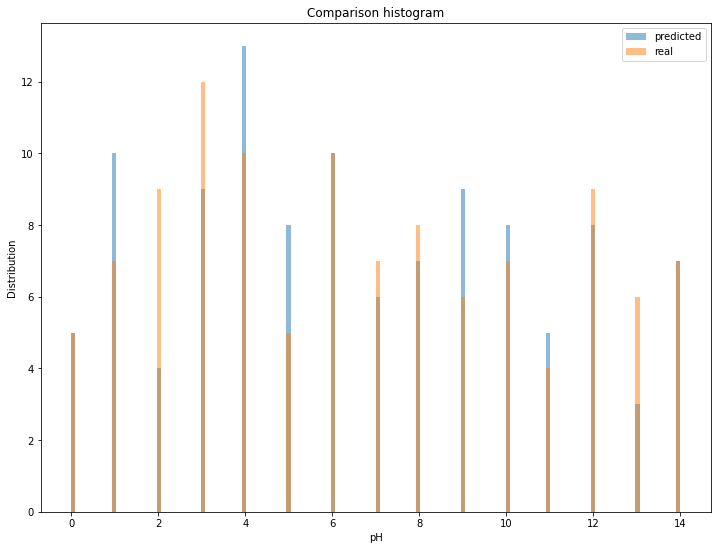

In [15]:
plt.figure(figsize=[12,9])

plt.hist(xgb_pred.round(), bins = 150,label = 'predicted', alpha=.5)
plt.hist(target_test,bins = 150, alpha=.5,label = 'real')

plt.xlabel("pH")
plt.ylabel("Distribution")
plt.legend()

plt.title("Comparison histogram")
plt.show()